In [1]:
import numpy as np
import itertools

A = np.array([[.7,.3],[.4,.6]])
B = np.array([[.1,.4,.5],[.7,.2,.1]])
pi = np.array([.6,.4])

In [2]:
def calc_prob1(obs):
    """Calculate probabilities using a brute-force method."""
    total = 0
    for st in tuple(itertools.product([0,1], repeat=4)):
        mid = 1
        for i in [0,1,2]:
            mid *= B[st[i], obs[i]]*A[st[i], st[i+1]]
            
        total += pi[st[0]]*mid*B[st[3], obs[3]]
    return total

In [3]:
observations = tuple(itertools.product([0,1,2], repeat=4))
probs1 = {obs:calc_prob1(obs) for obs in observations}
print "Total Probability:", np.sum(probs1.values())

Total Probability: 1.0


In [4]:
def calc_probs2(obs):
    """Calculate probabilities recurisvely."""
    alpha = np.zeros((4,2))
    alpha[0,:] = [pi[0]*B[0,obs[0]], pi[1]*B[1, obs[0]]]
    for t in [1,2,3]:
        alpha[t,0] = (alpha[t-1,0]*A[0,0] + alpha[t-1,1]*A[1,0])*B[0,obs[t]]
        alpha[t,1] = (alpha[t-1,0]*A[0,1] + alpha[t-1,1]*A[1,1])*B[1,obs[t]]

    return alpha.sum(axis=1)[-1]

In [5]:
observations = tuple(itertools.product([0,1,2], repeat=4))
probs2 = {obs:calc_probs2(obs) for obs in observations}
print "Total Probability:", np.sum(probs2.values())

Total Probability: 1.0


In [6]:
def check_equality(p1, p2):
    """Check to make sure dictionaries p1 and p2 are equal with
    with keys defined as 'observations'."""
    observations = tuple(itertools.product([0,1,2], repeat=4))
    for obs in observations:
        if np.allclose(p1[obs],p2[obs]):
            continue
        else:
            print "Answers do not agree for observation:", obs
            return False
    return True

In [7]:
print "All Equal?", check_equality(probs1, probs2)

All Equal? True


# Homework 3/31

### Written Homework

#### Problem 2

a) Looking at the table of probabilities in Problem 1, the state producing the highest probability is $CCH$.

b) Looking at the table of values resulting from the $\alpha$ pass algorithm, we take a row-wise argmax of the resulting alpha matrix to get $CCH$.

#### Problem 4

9) $$\pi_i = \gamma_0(i) = \frac{\alpha_0(i)\beta_0(i)}{P(O|\lambda)} = \frac{\alpha_0(i)\beta_0(i)}{\sum^{N-1}_{i=0}\alpha_{T-1}(i)}$$

10) $$a_{ij} = \frac{\sum^{T-2}_{t=0}\gamma_t(i,j)}{\sum^{T-2}_{t=0}\gamma_t(i)} = 
\frac{\sum^{T-2}_{t=0}\frac{\alpha_t(i)a_{ij}b_j(O_{t+1})\beta_{t+1}(j)}{P(O | \lambda)}}{\sum^{T-2}_{t=0}\frac{\alpha_t(i)\beta_t(i)}{P(O | \lambda)}} = 
\frac{\sum^{T-2}_{t=0}\alpha_t(i)a_{ij}b_j(O_{t+1})\beta_{t+1}(j)}{\sum^{T-2}_{t=0}\alpha_t(i)\beta_t(i)}$$ 

11) $$b_j(k) = \frac{\sum_{t \in \{0,1,...,T-1\}, O_t=k} \gamma_t(j)}{\sum^{T-1}_{t=0}\gamma_t(j)} =
\frac{\sum_{t \in \{0,1,...,T-1\}, O_t=k} \frac{\alpha_t(i)\beta_t(i)}{P(O | \lambda)}}{\sum^{T-1}_{t=0}\frac{\alpha_t(i)\beta_t(i)}{P(O | \lambda)}} = 
\frac{\sum_{t \in \{0,1,...,T-1\}, O_t=k}\alpha_t(i)\beta_t(i)}{\sum^{T-1}_{t=0}\alpha_t(i)\beta_t(i)}$$

In [8]:
import numpy as np

A = np.array([[.7,.3],[.4,.6]])
B = np.array([[.1,.4,.5],[.7,.2,.1]])
pi = np.array([.6,.4])

obs = [0,1,0,1]

delta = np.zeros((4,2))
delta[0,:] = [pi[0]*B[0,obs[0]], pi[1]*B[1, obs[0]]]
for t in [1,2,3]:
    delta[t,0] = np.maximum(delta[t-1,0]*A[0,0], delta[t-1,1]*A[1,0])*B[0,obs[t]]
    delta[t,1] = np.maximum(delta[t-1,0]*A[0,1], delta[t-1,1]*A[1,1])*B[1,obs[t]]

In [12]:
np.argmax(delta, axis=1)

array([1, 0, 1, 0])

# Homework 4/3

### Problems 1-6

In [1]:
from __future__ import division
import numpy as np
import string
import codecs
import matplotlib.pyplot as plt

def vec_translate(a, my_dict):
    # translate numpy array from symbols to state numbers or vice versa
    return np.vectorize(my_dict.__getitem__)(a)

def prep_data(filename):
    # Get the data as a single string
    with codecs.open(filename, encoding='utf-8') as f:
        data=f.read().lower() #and convert to all lower case
    
    # remove punctuation and newlines
    remove_punct_map = {ord(char): None for char in string.punctuation+"\n\r"}
    
    data = data.translate(remove_punct_map)
    
    # make a list of the symbols in the data
    symbols = sorted(list(set(data)))
    
    # convert the data to a NumPy array of symbols
    a = np.array(list(data))
    
    #make a conversion dictionary from symbols to state numbers
    symbols_to_obsstates = {x:i for i,x in enumerate(symbols)}
    
    #convert the symbols in a to state numbers
    obs_sequence = vec_translate(a,symbols_to_obsstates)
    return symbols, obs_sequence

class hmm(object):
    def __init__(self):
        self.A = None
        self.B = None
        self.pi = None
    
    def _forward(self, obs):
        """
        Compute the scaled forward probability matrix and scaling factors.
        Parameters
        ----------
        obs : ndarray of shape (T,)
               The observation sequence

        Returns
        -------
        alpha : ndarray of shape (T,N)
                 The scaled forward probability matrix
        c : ndarray of shape (T,)
             The scaling factors c = [c_1,c_2,...,c_T]
        """
        alpha = np.zeros((len(obs), len(self.pi)))
        
        c1 = 1/(np.dot(self.pi, self.B[obs[0],:]))
        alpha[0,:] = c1*(self.pi*self.B[obs[0],:])
        
        c = [c1]
        for t in xrange(1,len(obs)):
            ct = 1/(self.A.dot(alpha[t-1,:]).dot(self.B[obs[t],:]))
            alpha[t,:] = ct*self.A.dot(alpha[t-1,:])*self.B[obs[t],:]
            c.append(ct)
        
        return alpha, np.array(c)
    
    def _backward(self, obs, c):
        """
        Compute the scaled backward probability matrix.
        
        Parameters
        ----------
        obs : ndarray of shape (T,)
               The observation sequence
        c : ndarray of shape (T,)
             The scaling factors from the forward pass
        
        Returns
        -------
        beta : ndarray of shape (T,N)
                The scaled backward probability matrix
        """
        beta = np.zeros((len(obs), len(self.pi)))
        cT = c[-1]
        
        beta[-1,:] = cT
        for t in xrange(len(obs)-2,-1,-1):
            beta[t,:] = c[t]*self.A.T.dot(self.B[obs[t+1],:]*beta[t+1,:])
        return beta
    
    def _delta(self, obs, alpha, beta):
        """
        Compute the delta probabilities.
        
        Parameters
        ----------
        obs : ndarray of shape (T,)
            The observation sequence
        alpha : ndarray of shape (T,N)
            The scaled forward probability matrix from the forward pass
        beta : ndarray of shape (T,N)
            The scaled backward probability matrix from the backward pass
        
        Returns
        -------
        delta : ndarray of shape (T-1,N,N)
              The delta probability array
        gamma : ndarray of shape (T,N)
              The gamma probability array
        """
        delta = np.zeros((len(obs)-1, len(self.pi), len(self.pi)))
        gamma = np.zeros((len(obs), len(self.pi)))
        
        for t in xrange(delta.shape[0]):
            denom = 0
            for l in xrange(self.A.shape[0]):
                for k in xrange(self.A.shape[1]):
                    denom += alpha[t,k]*self.A[l,k]*self.B[obs[t+1], l]*beta[t+1,l]
            
            for i in xrange(delta.shape[1]):
                for j in xrange(delta.shape[2]):
                    num = alpha[t,i]*A[j,i]*B[obs[t+1], j]*beta[t+1,j]
                    delta[t,i,j] = num/denom
                  
        gamma[0:-1,:] = delta.sum(axis=2)
        gamma[-1,:] = alpha[-1,:]*beta[-1,:]/np.dot(alpha[-1,:],beta[-1,:])
        
        return delta, gamma
    
    def _estimate(self, obs, delta, gamma):
        """
        Estimate better parameter values.
        
        Parameters
        ----------
        obs : ndarray of shape (T,)
            The observation sequence
        delta : ndarray of shape (T-1,N,N)
            The delta probability array
        gamma : ndarray of shape (T,N)
            The gamma probability array
        """
        # update self.A, self.B, self.pi in place
        for i in xrange(self.A.shape[0]):
            for j in xrange(self.A.shape[1]):
                num = 0
                denom = 0
                for t in xrange(0,len(obs)-1):
                    num += delta[t,j,i]
                    denom += gamma[t,j]
                self.A[i,j] = num/denom

        for i in xrange(self.B.shape[0]):
            for j in xrange(self.B.shape[1]):
                self.B[i,j] = np.sum(gamma[:,j]*(obs==i)) / gamma[:,j].sum()
                
        self.pi = gamma[0,:]
        
    def fit(self, obs, A, B, pi, max_iter=200, tol=1e-3):
        """
        Fit the model parameters to a given observation sequence.
        Parameters
        ----------
        obs : ndarray of shape (T,)
           Observation sequence on which to train the model.
        A : stochastic ndarray of shape (N,N)
           Initialization of state transition matrix
        B : stochastic ndarray of shape (M,N)
           Initialization of state observation matrix
        pi : stochastic ndarray of shape (N,)
           Initialization of initial state distribution
        max_iter : integer
           The maximum number of iterations to take
        tol : float
           The convergence threshold for change in log-probability
        """
        # initialize self.A, self.B, self.pi
        self.A = A
        self.B = B
        self.pi = pi
        
        # run the iteration
        log_probs = [0]
        
        for i in xrange(max_iter):
            alpha, c = self._forward(obs)
            log_prob1 = -(np.log(c)).sum()
            
            if np.abs(log_prob1 - log_probs[-1]) < tol:
                log_probs.append(log_prob1)
               
                break
            else:
                log_probs.append(log_prob1)
            
            beta = self._backward(obs, c)
            delta, gamma = self._delta(obs, alpha, beta)
            self._estimate(obs, delta, gamma)
    
       
        print log_probs[-1]
        
        plt.plot(log_probs[1:])
        plt.show()

### Problem 7

maxiters reached
-21508.2480829


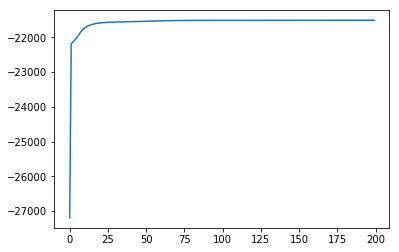

In [206]:
N = 2

symbols, obs = prep_data('declaration.txt')
M = len(set(obs))
A = np.random.dirichlet(np.ones(N), size=N).T
B = np.random.dirichlet(np.ones(M), size=N).T
pi = np.random.dirichlet(np.ones(N))

h = hmm()
h.fit(obs, A, B, pi)

My results accurately distinguish between a vowel and a consonant.

In [207]:
for i in xrange(len(h.B)):
    print "{0}, {1:0.4f}, {2:0.4f}".format(symbols[i], h.B[i,0], h.B[i,1])

 , 0.0123, 0.3275
a, 0.0000, 0.1257
b, 0.0236, 0.0000
c, 0.0456, 0.0000
d, 0.0625, 0.0000
e, 0.0000, 0.2265
f, 0.0446, 0.0000
g, 0.0322, 0.0000
h, 0.0818, 0.0050
i, 0.0000, 0.1184
j, 0.0040, 0.0000
k, 0.0031, 0.0004
l, 0.0565, 0.0000
m, 0.0357, 0.0000
n, 0.1198, 0.0000
o, 0.0003, 0.1349
p, 0.0342, 0.0000
q, 0.0015, 0.0000
r, 0.1054, 0.0000
s, 0.1185, 0.0000
t, 0.1587, 0.0000
u, 0.0000, 0.0551
v, 0.0183, 0.0000
w, 0.0241, 0.0000
x, 0.0022, 0.0000
y, 0.0141, 0.0064
z, 0.0010, 0.0000


### Problem 8
It is difficult to detect specifically what the characteristics of the resulting clusters are when N = 3,4.

In [2]:
N = 3

symbols, obs = prep_data('declaration.txt')
M = len(set(obs))
A = np.random.dirichlet(np.ones(N), size=N).T
B = np.random.dirichlet(np.ones(M), size=N).T
pi = np.random.dirichlet(np.ones(N))

h = hmm()
h.fit(obs, A, B, pi)

KeyboardInterrupt: 

In [209]:
for i in xrange(len(h.B)):
    print u"{0}, {1:0.4f}, {2:0.4f}, {3:0.4f}".format(symbols[i], h.B[i,0], h.B[i,1], h.B[i,2])

 , 0.0116, 0.2728, 0.2103
a, 0.0000, 0.1757, 0.0000
b, 0.0345, 0.0000, 0.0016
c, 0.0545, 0.0000, 0.0164
d, 0.0308, 0.0000, 0.0690
e, 0.0000, 0.1767, 0.1531
f, 0.0587, 0.0000, 0.0102
g, 0.0189, 0.0000, 0.0324
h, 0.0000, 0.0000, 0.1409
i, 0.0000, 0.1445, 0.0229
j, 0.0017, 0.0000, 0.0047
k, 0.0017, 0.0010, 0.0027
l, 0.0476, 0.0000, 0.0414
m, 0.0403, 0.0011, 0.0140
n, 0.1833, 0.0000, 0.0000
o, 0.0000, 0.1509, 0.0417
p, 0.0394, 0.0000, 0.0138
q, 0.0000, 0.0000, 0.0024
r, 0.1247, 0.0003, 0.0387
s, 0.1209, 0.0000, 0.0644
t, 0.1655, 0.0000, 0.0823
u, 0.0000, 0.0770, 0.0000
v, 0.0240, 0.0000, 0.0044
w, 0.0335, 0.0000, 0.0035
x, 0.0034, 0.0000, 0.0000
y, 0.0034, 0.0000, 0.0291
z, 0.0015, 0.0000, 0.0000


-20356.2047593


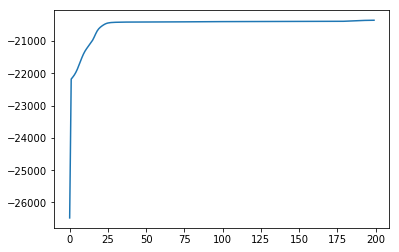

In [220]:
N = 4

symbols, obs = prep_data('declaration.txt')
M = len(set(obs))
A = np.random.dirichlet(np.ones(N), size=N).T
B = np.random.dirichlet(np.ones(M), size=N).T
pi = np.random.dirichlet(np.ones(N))

h = hmm()
h.fit(obs, A, B, pi)

In [221]:
for i in xrange(len(h.B)):
    print u"{0}, {1:0.4f}, {2:0.4f}, {3:0.4f}, {4:0.4f}".format(symbols[i], h.B[i,0], h.B[i,1], h.B[i,2], h.B[i,3])

 , 0.3084, 0.0000, 0.5180, 0.0000
a, 0.0000, 0.0000, 0.0186, 0.1875
b, 0.0000, 0.0337, 0.0041, 0.0000
c, 0.0021, 0.0553, 0.0204, 0.0000
d, 0.0005, 0.0944, 0.0000, 0.0033
e, 0.0273, 0.0000, 0.0000, 0.3535
f, 0.0131, 0.0630, 0.0023, 0.0000
g, 0.0064, 0.0479, 0.0000, 0.0000
h, 0.3120, 0.0000, 0.0000, 0.0190
i, 0.0759, 0.0000, 0.0348, 0.1309
j, 0.0045, 0.0045, 0.0000, 0.0000
k, 0.0001, 0.0048, 0.0000, 0.0006
l, 0.0787, 0.0395, 0.0258, 0.0000
m, 0.0071, 0.0440, 0.0122, 0.0000
n, 0.0000, 0.0403, 0.1980, 0.0000
o, 0.0043, 0.0000, 0.0035, 0.2133
p, 0.0199, 0.0416, 0.0059, 0.0000
q, 0.0000, 0.0023, 0.0000, 0.0000
r, 0.0882, 0.0983, 0.0444, 0.0000
s, 0.0000, 0.1305, 0.0507, 0.0186
t, 0.0449, 0.2272, 0.0007, 0.0035
u, 0.0056, 0.0000, 0.0533, 0.0431
v, 0.0000, 0.0286, 0.0000, 0.0000
w, 0.0009, 0.0341, 0.0042, 0.0000
x, 0.0000, 0.0013, 0.0029, 0.0000
y, 0.0000, 0.0070, 0.0000, 0.0267
z, 0.0000, 0.0015, 0.0000, 0.0000


### Problem 9

It appears as though 2 states did not detect anything immediately obvious, but to me it appears as though 3 states created more definitive groups. I hypothesize the 2 column corresponds to the "vowel" state.

-166514.367235


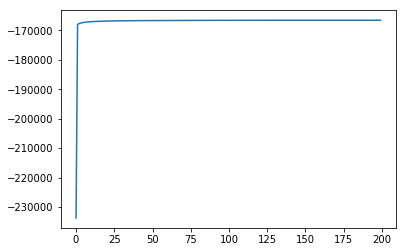

In [228]:
N = 2

symbols, obs = prep_data('WarAndPeace.txt')
M = len(set(obs))
A = np.random.dirichlet(np.ones(N), size=N).T
B = np.random.dirichlet(np.ones(M), size=N).T
pi = np.random.dirichlet(np.ones(N))

h = hmm()
h.fit(obs, A, B, pi)

In [229]:
for i in xrange(len(h.B)):
    print u"{0}, {1:0.4f}, {2:0.4f}".format(symbols[i], h.B[i,0], h.B[i,1])

 , 0.1707, 0.1609
́, 0.0000, 0.0001
а, 0.1902, 0.0169
б, 0.0000, 0.0217
в, 0.0289, 0.0440
г, 0.0046, 0.0236
д, 0.0091, 0.0294
е, 0.0000, 0.0980
ж, 0.0050, 0.0099
з, 0.0492, 0.0000
и, 0.0736, 0.0445
й, 0.0000, 0.0130
к, 0.0732, 0.0111
л, 0.0686, 0.0319
м, 0.0103, 0.0285
н, 0.0794, 0.0491
о, 0.0000, 0.1390
п, 0.0025, 0.0325
р, 0.0149, 0.0452
с, 0.0589, 0.0345
т, 0.0256, 0.0563
у, 0.0123, 0.0286
ф, 0.0039, 0.0000
х, 0.0001, 0.0096
ц, 0.0040, 0.0025
ч, 0.0058, 0.0142
ш, 0.0056, 0.0070
щ, 0.0012, 0.0036
ъ, 0.0000, 0.0004
ы, 0.0000, 0.0217
ь, 0.0312, 0.0119
э, 0.0000, 0.0038
ю, 0.0048, 0.0061
я, 0.0664, 0.0005
ё, 0.0000, 0.0001


-153574.222127


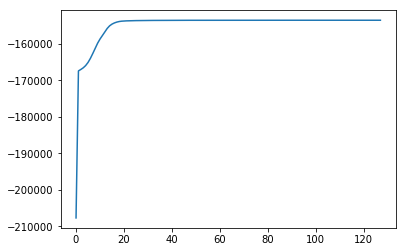

In [226]:
N = 3

symbols, obs = prep_data('WarAndPeace.txt')
M = len(set(obs))
A = np.random.dirichlet(np.ones(N), size=N).T
B = np.random.dirichlet(np.ones(M), size=N).T
pi = np.random.dirichlet(np.ones(N))

h = hmm()
h.fit(obs, A, B, pi)

In [227]:
for i in xrange(len(h.B)):
    print u"{0}, {1:0.4f}, {2:0.4f}, {3:0.4f}".format(symbols[i], h.B[i,0], h.B[i,1], h.B[i,2])

 , 0.0980, 0.0425, 0.4196
́, 0.0000, 0.0000, 0.0002
а, 0.0000, 0.1967, 0.0000
б, 0.0327, 0.0000, 0.0103
в, 0.0716, 0.0000, 0.0466
г, 0.0372, 0.0000, 0.0142
д, 0.0453, 0.0010, 0.0216
е, 0.0000, 0.1535, 0.0486
ж, 0.0188, 0.0000, 0.0050
з, 0.0272, 0.0000, 0.0186
и, 0.0000, 0.1427, 0.0094
й, 0.0000, 0.0000, 0.0336
к, 0.0581, 0.0000, 0.0316
л, 0.0920, 0.0000, 0.0322
м, 0.0432, 0.0000, 0.0249
н, 0.1307, 0.0000, 0.0349
о, 0.0000, 0.2672, 0.0026
п, 0.0464, 0.0000, 0.0218
р, 0.0865, 0.0000, 0.0124
с, 0.0434, 0.0003, 0.0959
т, 0.1042, 0.0000, 0.0286
у, 0.0000, 0.0646, 0.0018
ф, 0.0021, 0.0000, 0.0016
х, 0.0122, 0.0000, 0.0077
ц, 0.0076, 0.0000, 0.0004
ч, 0.0202, 0.0000, 0.0149
ш, 0.0147, 0.0000, 0.0038
щ, 0.0076, 0.0000, 0.0000
ъ, 0.0002, 0.0006, 0.0000
ы, 0.0000, 0.0420, 0.0000
ь, 0.0000, 0.0500, 0.0000
э, 0.0000, 0.0000, 0.0098
ю, 0.0000, 0.0029, 0.0175
я, 0.0000, 0.0359, 0.0298
ё, 0.0000, 0.0001, 0.0000


# Homework 4/6

In [172]:
def generate_ghmm_samples(T, pi, A, mu, Sigma):
    x0 = np.random.choice(np.arange(len(pi)), p=pi)
    z0 = np.random.multivariate_normal(mu[x0], Sigma[x0])
    
    x = [x0]
    z = [z0]
    
    for t in xrange(1,T):
        xt = np.random.choice(np.arange(len(pi)), p=A[x[-1]])
        zt = np.random.multivariate_normal(mu[xt], Sigma[xt])
        
        x.append(xt)
        z.append(zt)
       
    return z

In [153]:
from __future__ import division
import numpy as np
import string
import codecs
import matplotlib.pyplot as plt
import scipy.stats as stats

class continuous_hmm(object):
    def __init__(self):
        self.A = None
        self.mu = None
        self.Sigma = None
        self.pi = None
    
    # NEW CODE
    def B(self, ob, state):
        if state == ':':
            out = np.zeros(len(self.pi))
            for i in xrange(len(out)):
                out[i] = stats.multivariate_normal(mu[i], Sigma[i]).pdf(ob)
            return out
        else:
            return stats.multivariate_normal(mu[state], Sigma[state]).pdf(ob)
    
    def _forward(self, obs):
        """
        Compute the scaled forward probability matrix and scaling factors.
        Parameters
        ----------
        obs : ndarray of shape (T,)
               The observation sequence

        Returns
        -------
        alpha : ndarray of shape (T,N)
                 The scaled forward probability matrix
        c : ndarray of shape (T,)
             The scaling factors c = [c_1,c_2,...,c_T]
        """
        alpha = np.zeros((len(obs), len(self.pi)))
        
        c1 = 1/(np.dot(self.pi, self.B(obs[0],':')))
        alpha[0,:] = c1*(self.pi*self.B(obs[0],':'))
        
        c = [c1]
        for t in xrange(1,len(obs)):
            ct = 1/(self.A.dot(alpha[t-1,:]).dot(self.B(obs[t],':')))
            alpha[t,:] = ct*self.A.dot(alpha[t-1,:])*self.B(obs[t],':')
            c.append(ct)
        
        return alpha, np.array(c)
    
    def _backward(self, obs, c):
        """
        Compute the scaled backward probability matrix.
        
        Parameters
        ----------
        obs : ndarray of shape (T,)
               The observation sequence
        c : ndarray of shape (T,)
             The scaling factors from the forward pass
        
        Returns
        -------
        beta : ndarray of shape (T,N)
                The scaled backward probability matrix
        """
        beta = np.zeros((len(obs), len(self.pi)))
        cT = c[-1]
        
        beta[-1,:] = cT
        for t in xrange(len(obs)-2,-1,-1):
            beta[t,:] = c[t]*self.A.T.dot(self.B(obs[t+1],':')*beta[t+1,:])
        return beta
    
    def _delta(self, obs, alpha, beta):
        """
        Compute the delta probabilities.
        
        Parameters
        ----------
        obs : ndarray of shape (T,)
            The observation sequence
        alpha : ndarray of shape (T,N)
            The scaled forward probability matrix from the forward pass
        beta : ndarray of shape (T,N)
            The scaled backward probability matrix from the backward pass
        
        Returns
        -------
        delta : ndarray of shape (T-1,N,N)
              The delta probability array
        gamma : ndarray of shape (T,N)
              The gamma probability array
        """
        delta = np.zeros((len(obs)-1, len(self.pi), len(self.pi)))
        gamma = np.zeros((len(obs), len(self.pi)))
        
        for t in xrange(delta.shape[0]):
            denom = 0
            for l in xrange(self.A.shape[0]):
                for k in xrange(self.A.shape[1]):
                    denom += alpha[t,k]*self.A[l,k]*self.B(obs[t+1], l)*beta[t+1,l]
            
            for i in xrange(delta.shape[1]):
                for j in xrange(delta.shape[2]):
                    num = alpha[t,i]*A[j,i]*self.B(obs[t+1], j)*beta[t+1,j]
                    delta[t,i,j] = num/denom
                  
        gamma[0:-1,:] = delta.sum(axis=2)
        gamma[-1,:] = alpha[-1,:]*beta[-1,:]/np.dot(alpha[-1,:],beta[-1,:])
        
        return delta, gamma
    
    def _estimate(self, obs, delta, gamma):
        """
        Estimate better parameter values.
        
        Parameters
        ----------
        obs : ndarray of shape (T,)
            The observation sequence
        delta : ndarray of shape (T-1,N,N)
            The delta probability array
        gamma : ndarray of shape (T,N)
            The gamma probability array
        """
        # update self.A, self.B, self.pi in place
        for i in xrange(self.A.shape[0]):
            for j in xrange(self.A.shape[1]):
                num = 0
                denom = 0
                for t in xrange(0,len(obs)-1):
                    num += delta[t,j,i]
                    denom += gamma[t,j]
                self.A[i,j] = num/denom
        
        self.A = self.A / self.A.sum(axis=1).reshape(2,1)
        
        # NEW CODE
        for i in xrange(len(self.mu)):
            self.mu[i] = np.zeros_like(self.mu[i])
            for t in xrange(len(obs)):
                self.mu[i] += (gamma[t,i]*obs[t]) / gamma[:,i].sum()
            
            
            self.Sigma[i] = np.zeros_like(self.Sigma[i])
            for t in xrange(len(obs)):
                self.Sigma[i] += gamma[t,i]*np.outer(obs[t] - self.mu[i], obs[t] - self.mu[i]) / np.sum(gamma[:,i])
            
        
        """
        for i in xrange(self.B.shape[0]):
            for j in xrange(self.B.shape[1]):
                self.B[i,j] = np.sum(gamma[:,j]*(obs==i)) / gamma[:,j].sum()
        """
        
        self.pi = gamma[0,:]
        self.pi /= self.pi.sum()
        
    def fit(self, obs, A, mu, Sigma, pi, max_iter=200, tol=1e-4):
        """
        Fit the model parameters to a given observation sequence.
        Parameters
        ----------
        obs : ndarray of shape (T,)
           Observation sequence on which to train the model.
        A : stochastic ndarray of shape (N,N)
           Initialization of state transition matrix
        B : stochastic ndarray of shape (M,N)
           Initialization of state observation matrix
        pi : stochastic ndarray of shape (N,)
           Initialization of initial state distribution
        max_iter : integer
           The maximum number of iterations to take
        tol : float
           The convergence threshold for change in log-probability
        """
        # initialize self.A, self.B, self.pi
        self.A = A
        self.mu = mu
        self.Sigma = Sigma
        self.pi = pi
        
        # run the iteration
        log_probs = [0]
        
        for i in xrange(max_iter):
            alpha, c = self._forward(obs)
            log_prob1 = -(np.log(c)).sum()
            
            if np.abs(log_prob1 - log_probs[-1]) < tol:
                log_probs.append(log_prob1)
               
                break
            else:
                log_probs.append(log_prob1)
            
            beta = self._backward(obs, c)
            delta, gamma = self._delta(obs, alpha, beta)
            self._estimate(obs, delta, gamma)
    
       
        print log_probs[-1]
        
        plt.plot(log_probs[1:])
        plt.show()

In [166]:
T = 500
pi = np.array([.3,.7])
A = np.array([[.4,.6],[.9,.1]])
mu = [[2,0],[0,2]]
Sigma = [np.eye(2), np.diag([.5,1])]

obs = generate_ghmm_samples(T, pi, A, mu, Sigma)

-1594.29008109


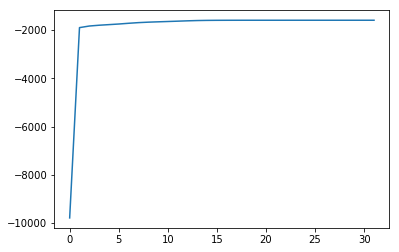

In [167]:
N = 2
A = np.random.rand(N,N)
mu = [np.random.rand(N), np.random.rand(N)]
Sigma = [np.diag(np.random.rand(2)), np.diag(np.random.rand(2))]
pi = np.random.rand(N)

g = continuous_hmm()
g.fit(obs, A, mu, Sigma, pi)

In [168]:
g.mu

[array([ 1.75762541,  0.04578295]),
 array([  7.77722286e-04,   2.16183432e+00])]

In [169]:
g.Sigma

[array([[ 1.30470861, -0.19209962],
        [-0.19209962,  1.11288193]]), array([[ 0.52612901,  0.07661601],
        [ 0.07661601,  0.86309037]])]

In [170]:
g.A

array([[ 0.49176134,  0.50823866],
       [ 0.98459372,  0.01540628]])

In [171]:
g.pi

array([  1.00000000e+000,   1.53191565e-244])

I didn't run it on all 5000 samples because it was taking too long. The results are respectable even without the full 5000 samples called for. The values for pi are definitely off, but the others are looking good.